In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../')
import pandas as pd
from src.gpt_prompt import get_sentiment_general, get_sentiment_general_parallel, get_risk_score
import datetime

In [2]:
df_news = pd.read_csv("../data/news_apple_2022.csv", index_col=0)
df_price = pd.read_csv("../data/price_apple_2022.csv", index_col=0)
df_news["date"] = pd.to_datetime(df_news['date'])
df_price["date"] = pd.to_datetime(df_price['date'])
print(df_news.head())
print(df_price.head())

                 date                                               news
0 2022-01-01 00:32:44  I actually lost weight this holiday season — t...
1 2022-01-01 00:52:34  January Dogs Of The Dow Need A PullbackThirty-...
2 2022-01-01 01:04:02  I switched from Android to iPhone — here's wha...
3 2022-01-01 01:36:26  365 Inspirational Quotes for 2022Inspiring, po...
4 2022-01-01 02:06:21  Is Fitbit Premium worth it? Here's the pros an...
                 date       price
0 2022-01-03 09:31:00  175.826576
1 2022-01-03 09:32:00  176.596792
2 2022-01-03 09:33:00  176.636290
3 2022-01-03 09:34:00  176.776509
4 2022-01-03 09:35:00  176.705412


In [3]:
df_score = pd.read_csv("../data/news_risk_apple_2022_4.csv", index_col=0)
df_score = df_score[["date", "score"]]
df_score["date"] = pd.to_datetime(df_score['date'])

In [4]:
df_score

,date,score
0,2022-01-01 04:11:47,20
1,2022-01-01 07:50:27,85
2,2022-01-01 12:28:24,85
3,2022-01-01 17:46:47,78
4,2022-01-02 04:49:58,45
...,...,...
4378,2022-12-30 17:40:26,65
4379,2022-12-30 20:48:24,85
4380,2022-12-31 07:05:30,65
4381,2022-12-31 12:34:14,85


In [5]:
date_price_dict = df_price.set_index('date')['price'].to_dict()
# date_price_dict

In [6]:
def find_whole_minute_time_after_n_minutes(time, n):
    new_time = time + pd.Timedelta(minutes=n)
    if new_time.second > 0:
        new_time += pd.Timedelta(minutes=1)
        new_time = new_time.replace(second=0, microsecond=0)
    return new_time

In [7]:
df_news.shape

(43832, 2)

In [8]:

columns = ["price_now", "price_in5", "price_in10", "price_in30", "price_in60"]
deltas = [0, 5, 10, 30, 60]
pd_price = np.zeros((df_news.shape[0], 5))

for i in range(df_news.shape[0]):
    time = df_news["date"][i]
    for j in range(5):
        delta = deltas[j]
        new_time = find_whole_minute_time_after_n_minutes(time, delta)
        if new_time in date_price_dict:
            pd_price[i, j] = date_price_dict[new_time]

In [9]:
pd_price = pd.DataFrame(pd_price, columns=columns)
result_df = pd.concat([df_news, pd_price], axis=1)

In [10]:
result_df.replace(0, pd.NA, inplace=True)
result_df = result_df.merge(df_score, on='date', how='left')
result_df["score"] = result_df["score"].astype(float)
result_df = result_df.dropna()



return_cols = ["return_in5", "return_in10", "return_in20", "return_in60"]
price_cols = ["price_in5", "price_in10", "price_in30", "price_in60"]

for i in range(4):
    result_df[return_cols[i]] = (result_df[price_cols[i]] - result_df["price_now"]) / result_df["price_now"]
    result_df[return_cols[i]] = result_df[return_cols[i]].astype(float)
for col in price_cols:
    result_df.drop(col, axis=1, inplace=True)
result_df

,date,news,price_now,score,return_in5,return_in10,return_in20,return_in60
115,2022-01-03 09:41:17,AirPods Pro 2 rumored to feature lossless audi...,178.087852,25.0,0.000222,-0.002329,0.004159,0.004269
125,2022-01-03 10:41:18,iPhone 14 tipped with hole-punch display along...,178.848194,75.0,0.000055,0.000000,-0.002761,0.001877
135,2022-01-03 11:21:50,"Apple iPhone demand is 'strong,' Wedbush says,...",178.744511,20.0,0.003011,0.003177,0.003066,0.002735
145,2022-01-03 12:07:32,U.S. stocks fluctuate after huge year; bonds f...,179.035811,75.0,-0.000634,0.000441,0.002482,0.003144
155,2022-01-03 13:00:21,: Tesla gets a more than $110 billion boost to...,179.40117,85.0,0.001211,0.001101,0.003578,0.004128
...,...,...,...,...,...,...,...,...
43645,2022-12-29 12:19:31,​U.S. stock rally gathers strength; Nasdaq 100...,129.46138,25.0,-0.000653,-0.001459,-0.005108,-0.004647
43655,2022-12-29 14:54:14,Peloton: The Problem Is The ProductPeloton is ...,129.053659,85.0,-0.000039,0.001194,0.000886,0.000963
43735,2022-12-30 10:07:00,Iridium: Assessing Benefits From A Potential S...,126.930526,85.0,0.001097,0.002507,0.006268,0.009715
43745,2022-12-30 11:45:31,NHL’s Bettman Has Plan to Keep Hockey a Big 4 ...,127.780773,87.0,0.001051,0.001440,0.003969,0.003152


In [11]:
result_df = result_df.dropna()

In [12]:
result_df.describe(include='all')

/var/folders/v0/_fszh3l96cz8c79p9psn63y80000gn/T/ipykernel_19277/3235814888.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  result_df.describe(include='all')


,date,news,price_now,score,return_in5,return_in10,return_in20,return_in60
count,1369,1369,1369.000000,1369.000000,1369.000000,1369.000000,1369.000000,1369.000000
unique,1367,1367,1286.000000,NaN,NaN,NaN,NaN,NaN
top,2022-12-08 13:46:51,VIZIO Honored with ITVT Awards for Leadership ...,173.707338,NaN,NaN,NaN,NaN,NaN
freq,2,2,3.000000,NaN,NaN,NaN,NaN,NaN
first,2022-01-03 09:41:17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2022-12-30 13:17:18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,59.585829,0.000034,0.000063,-0.000069,-0.000060
std,NaN,NaN,NaN,25.725840,0.002044,0.002943,0.004708,0.006449
min,NaN,NaN,NaN,10.000000,-0.011893,-0.022818,-0.026805,-0.033490
25%,NaN,NaN,NaN,35.000000,-0.001033,-0.001468,-0.002502,-0.003391


In [13]:
result_df.dtypes

date           datetime64[ns]
news                   object
price_now              object
score                 float64
return_in5            float64
return_in10           float64
return_in20           float64
return_in60           float64
dtype: object

In [14]:
correlation_matrix = result_df[["score", 'return_in5', 'return_in10', 'return_in20', 'return_in60']].corr()

In [15]:
correlation_matrix

,score,return_in5,return_in10,return_in20,return_in60
score,1.000000,-0.032864,-0.008567,0.008650,0.028249
return_in5,-0.032864,1.000000,0.720730,0.453034,0.310690
return_in10,-0.008567,0.720730,1.000000,0.613838,0.441810
return_in20,0.008650,0.453034,0.613838,1.000000,0.727409
return_in60,0.028249,0.310690,0.441810,0.727409,1.000000


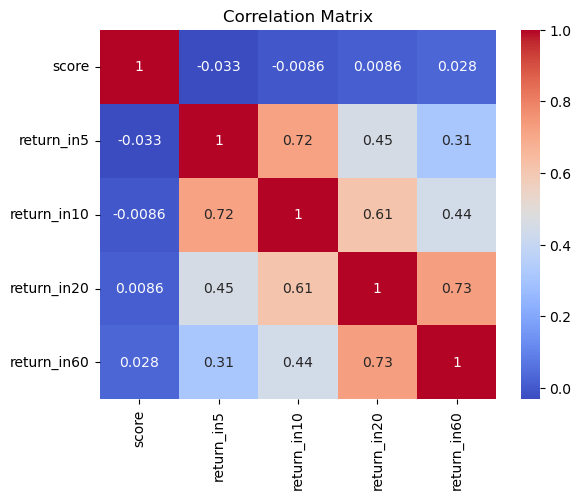

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

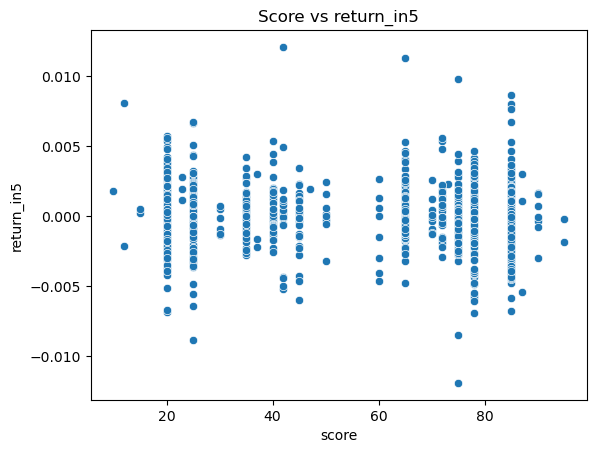

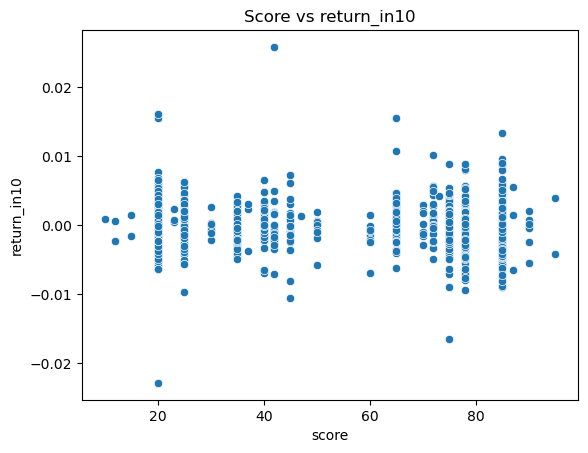

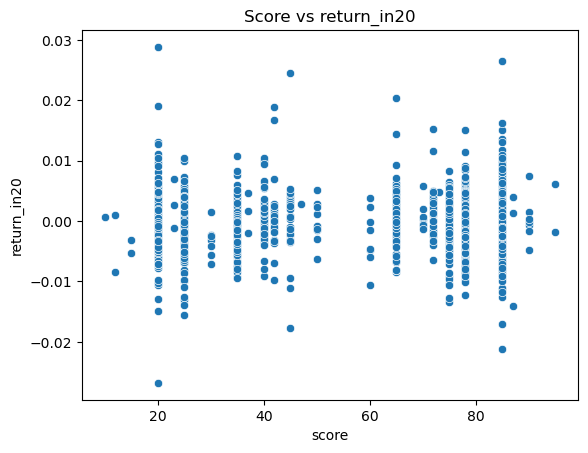

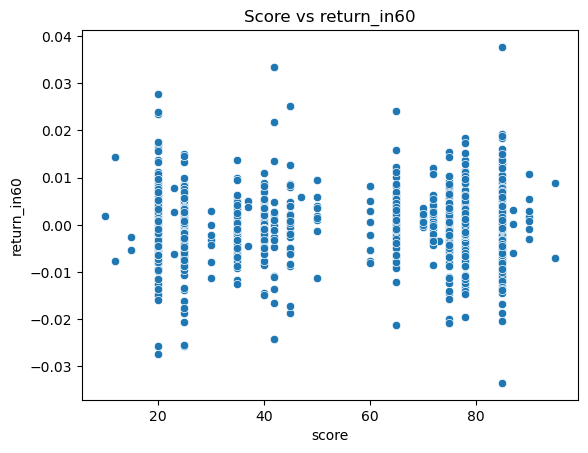

In [17]:
for return_col in ['return_in5', 'return_in10', 'return_in20', 'return_in60']:
    sns.scatterplot(x='score', y=return_col, data=result_df)
    plt.title(f'Score vs {return_col}')
    plt.show()

In [18]:
np.array(result_df[["return_in5", "return_in10","return_in20","return_in60"]]).shape

(1369, 4)

In [19]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
X = np.array(result_df["score"]).reshape(-1,1)
y = np.array(result_df[["return_in5", "return_in10","return_in20","return_in60"]])
lr.fit(X, y)

LinearRegression()

In [20]:
lr.coef_

array([[-2.61170559e-06],
       [-9.80180674e-07],
       [ 1.58309084e-06],
       [ 7.08161695e-06]])